In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!wget "https://www.dropbox.com/s/lk3qlysjlf8lhnp/model.h5"
!wget "https://www.dropbox.com/s/cu8vb0rk3s3r2xx/saved_model_eb2.zip"
!unzip -q "saved_model_eb2.zip"

In [3]:
# !cp "drive/My Drive/Personal/Projects/Object Detection/saved_model_eb2.zip" "/content"
# !unzip -q "saved_model_eb2.zip"

In [4]:
# !cp "drive/My Drive/Personal/Projects/Object Detection/model.h5" "/content"

In [5]:
import os 
import pathlib
from glob import glob 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%cd models/research
!pip install protobuf
!protoc object_detection/protos/*.proto --python_out=.
%cd ../..

In [ ]:
%cd models/research
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .
%cd ../..

In [ ]:
!wget https://www.dropbox.com/s/bj742qjgnp3zhh2/Dataset.zip

In [10]:
!unzip -q "Dataset.zip"

In [11]:
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
import json
import pandas as pd
import glob
import os.path as osp
from pathlib import Path
import datetime
import random
import shutil
from io import StringIO, BytesIO
from PIL import Image
from IPython.display import display
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})

from sklearn.model_selection import train_test_split

## Import object detection module
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_utils
from object_detection.protos.string_int_label_map_pb2 import StringIntLabelMap, StringIntLabelMapItem
from object_detection.utils import config_util
from object_detection.builders import model_builder

from google.protobuf import text_format

import tarfile
from numba import cuda 

# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [12]:
## EfficientDet Configurations
MODELS_CONFIG = {
    'mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz',
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
    },
    'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
    },
    'efficientdet-d4': {
        'model_name': 'efficientdet_d4_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d4_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d4_coco17_tpu-32.tar.gz',
    },
    'efficientdet-d5': {
        'model_name': 'efficientdet_d5_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d5_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d5_coco17_tpu-32.tar.gz',
    },
    'efficientdet-d6': {
        'model_name': 'efficientdet_d6_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d6_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d6_coco17_tpu-32.tar.gz',
    },
    'efficientdet-d7': {
        'model_name': 'efficientdet_d7_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d7_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d7_coco17_tpu-32.tar.gz',
    }
}

## Choosing D1 here for this tutorial
chosen_model = 'efficientdet-d2'
model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']

In [ ]:
model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'+pretrained_checkpoint
# pretrained_dir = "/kaggle/working/models/research/object_detection/pretrained"

!wget {model_url}
!tar -xf {pretrained_checkpoint}
!mv {model_name}/ {pretrained_dir}
!rm {pretrained_checkpoint}

In [ ]:
def convert_classes(classes, start=1):
    msg = StringIntLabelMap()
    for id, name in enumerate(classes, start=start):
        msg.item.append(StringIntLabelMapItem(id=id, name=name))
    text = str(text_format.MessageToBytes(msg, as_utf8=True), 'utf-8')
    return text

labels =  [
            "BoysShirt",
            "GirlsShirt",
            "BoysPant",
            "GirlsPant",
            "MenFootWear",
            "WomenFootWear"
            ]

txt = convert_classes(labels)
print(txt)
with open('labelmap.pbtxt', 'w') as f:
    f.write(txt)

In [15]:
## Get the Total Number of Classes

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

val_record_fname = 'training_job/tfrecords/test.record'
train_record_fname = 'training_job/tfrecords/train.record'
label_map_pbtxt_fname = 'labelmap.pbtxt'

# pipeline_file = os.|e Path", fine_tune_checkpoint)

In [16]:
## Training Configurations
num_epochs = 10
num_steps = 4000
num_eval_steps = 100
batch_size = 1
print("Number of Steps:", num_steps)

Number of Steps: 4000


In [17]:
model_dir = "training_job/model_files/training/"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print('Training Files:', model_dir)

Training Files: training_job/model_files/training/


In [18]:
## Checking GPU Load
# !nvidia-smi

In [19]:
import numpy as np

import sys
import cv2
import glob
import os.path as osp
from pathlib import Path
import random
import io
import scipy.misc
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})

import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [ ]:
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py

In [21]:
from inferenceutils import *

In [22]:
output_directory = 'inference_graph/'

In [23]:
category_index = label_map_util.create_category_index_from_labelmap("/content/labelmap.pbtxt", use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'/content/{output_directory}/saved_model')

In [24]:
import math, re, os, gc
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB3
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

with strategy.scope():
    main_model = EfficientNetB3(
        input_shape=(892, 892, 3),
        include_top=False,
        weights="imagenet"
    )

    classification_model = tf.keras.Sequential([
        # data_augmentation,
        main_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
            
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

classification_model.load_weights("model.h5")

REPLICAS:  1
43950080/43941136 [==============================] - 2s 0us/step


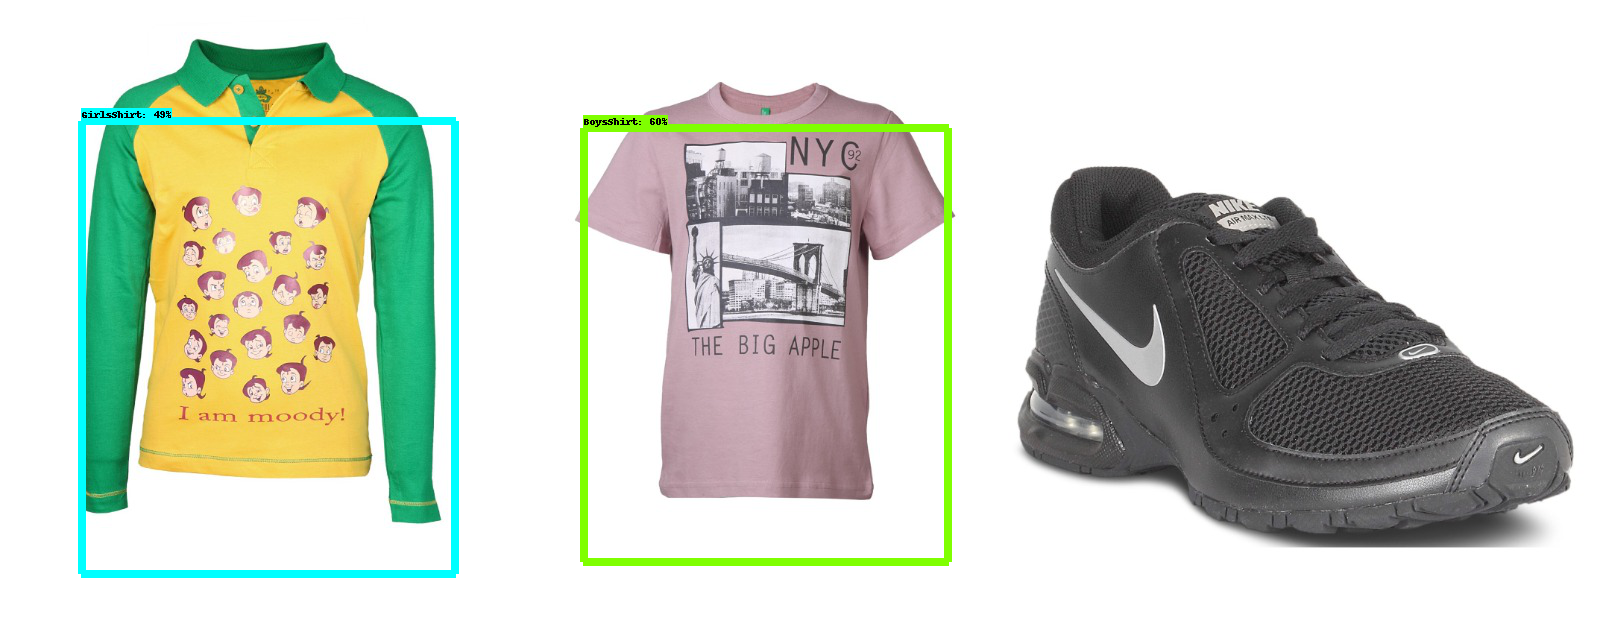

 Total Cart Price :  30


In [26]:
images = []

price_mapping = {0 : 10, 1 : 15, 2 : 20}

for e, image_name in enumerate(['Testing.jpeg']):
#   print(outputs[e])
  total_price = 0
  image_np = load_image_into_numpy_array('/content/' + image_name)
  output_dict = run_inference_for_single_image(model, image_np)
#   print(output_dict)
  # print(output_dict)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8,
      min_score_thresh=0.45)
  boxes = output_dict['detection_boxes'][output_dict['detection_scores'] > 0.45]
#   print(boxes)
  width, height = image_np.shape[0] , image_np.shape[1]
  for box in boxes:
      box = tuple(box.tolist())
      ymin, xmin, ymax, xmax = box
      left, right, top, bottom = int(xmin*width), int(xmax * width),int(ymin * height), int(ymax * height)
      image = image_np[left : right, top : bottom, :]
      image = cv2.resize(image, (892,892)).reshape(1, 892, 892, 3)
      prediction = np.argmax(classification_model.predict(image))
      total_price += price_mapping[prediction]
  display(Image.fromarray(image_np))
print(" Total Cart Price : ", total_price)